In [84]:
import pandas as pd
import numpy as np
from sklearn import preprocessing

def load_data(dataset_path: str) -> tuple[pd.DataFrame, pd.DataFrame]:
    """
    Load data from a CSV file.

    Parameters:
    dataset_path (str): The path to the CSV file.

    Returns:
    tuple: A tuple containing the features (x) and the labels (y).
    """
    raw_df = pd.read_csv(dataset_path)
    x, y = raw_df.iloc[:, 1:-1], raw_df.iloc[:, -1]
    y = np.logical_not(preprocessing.LabelEncoder().fit(y).transform(y)).astype(int)
    return x, y


DATASET = "GODataset"

x, y = load_data(f"../Data/Datasets/{DATASET}.csv")

# Filter all features in x which appear less than 5 times (binary so can use sum)
x = x.loc[:, (x.sum(axis=0) >= 5)]

x = x.to_numpy()

In [85]:
from sklearn.metrics import pairwise_distances

jaccard_distances = pairwise_distances(x, metric='jaccard')


c:\Users\Komi\Documents\GitHub\DR_Gene_Prediction_XofN_PUL\venv310\lib\site-packages\sklearn\metrics\pairwise.py:2008: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)


In [86]:
U = x[np.where(y == 0)]

U_row = np.expand_dims(U.sum(axis=1), axis=1)
D_col = np.expand_dims(x.T.sum(axis=0), 0)

R = np.zeros((len(U), len(x)))

R += U_row 
R += D_col
# print(D_col)

R -= U @ x.T

print(R)


[[ 2.  3. 11. ...  3.  3.  2.]
 [ 3.  3. 12. ...  4.  4.  3.]
 [11. 12. 11. ... 12. 12. 11.]
 ...
 [ 3.  4. 12. ...  1.  2.  1.]
 [ 3.  4. 12. ...  2.  1.  1.]
 [ 2.  3. 11. ...  1.  1.  0.]]


In [87]:
pos = np.where(y == 0)[0]
for i in range(len(U)):
    R[i, :pos[i]+1] = np.NaN
    # R[i, pos[i]] = np.NaN


68.0


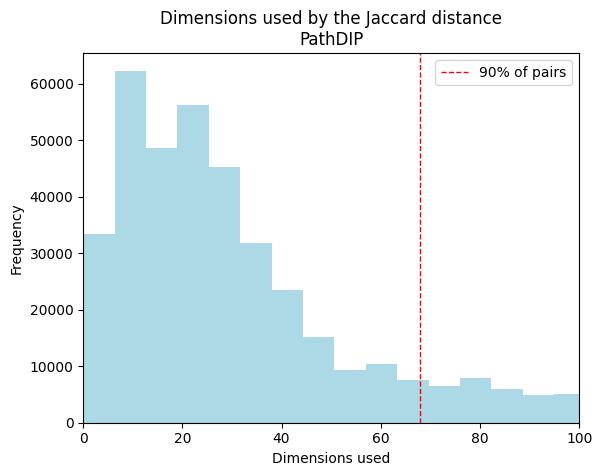

In [88]:
# Plot a histogram of the values in R
import matplotlib.pyplot as plt

plt.hist(R.flatten(), bins=100, color='lightblue')
p90 = np.nanpercentile(R, 80)
print(p90)
plt.axvline(p90, color='r', linestyle='dashed', linewidth=1, label='90% of pairs')
plt.xlim(0, 1000)
# plt.xticks(np.arange(0, 101, 10))
plt.xlabel('Dimensions used')
plt.ylabel('Frequency')
plt.title('Dimensions used by the Jaccard distance\nGO')
plt.legend()
plt.show()

In [89]:
# Reduce the distances matrix to the top10 values per row
# Make the diaGOnal values NaN
jaccard_distances[np.diag_indices_from(jaccard_distances)] = np.NaN
jaccard_distances_u = jaccard_distances[np.where(y == 0)]
jaccard_top10_closest = np.zeros((jaccard_distances_u.shape[0], 10))
jaccard_top10_percent = np.zeros(jaccard_distances_u.shape[0])
for i in range(len(U)):
    top10 = np.argsort(jaccard_distances_u[i])[:10]
    
    # Count how many of those top10 correspond to an unlabeled sample
    jaccard_top10_percent[i] = np.sum(y[top10] == 0) / 10
    jaccard_top10_closest[i] = jaccard_distances_u[i, top10]

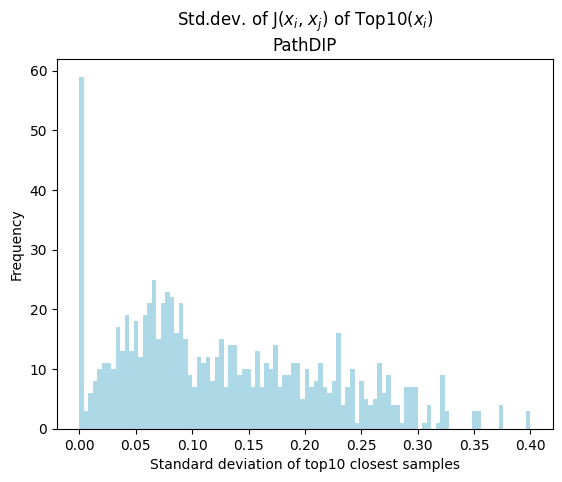

[0.66666667 0.66666667 0.66666667 0.66666667 0.66666667 0.66666667
 0.66666667 0.66666667 0.66666667 0.66666667]
[0.99 0.99 0.99 0.99 0.99 0.99 0.99 0.99 0.99 0.99]
[1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
[1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
[1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
[0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5]
[1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
[1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
[1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
[1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
[1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
[1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
[1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
[1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
[1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
[1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
[1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
[1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
[1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
[1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
[1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
[1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
[1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
[1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
[1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
[0.99386503 0.99386503 0.99386503 0.99386503 0.99386503 0.99386503
 0.99386503 0.99386503

In [92]:
# Plot a histogram of the standard deviations of the top10 values per row
stds = np.nanstd(jaccard_top10_closest, axis=1) 
plt.hist(stds, bins=100, color='lightblue')
plt.xlabel('Standard deviation of top10 closest samples')
plt.ylabel('Frequency')
plt.title('Std.dev. of J($x_i$, $x_j$) of Top10($x_i$)\nGO')
plt.show()

# Print the top10 of all the rows with std 0
stds_0 = np.where(stds == 0)[0]
for i in stds_0:
    print(jaccard_distances[i][np.argsort(jaccard_distances_u[i])[:10]])

[0.9 0.9 0.1 0.9 1.  1.  1.  0.9 1.  1.  1.  1.  1.  0.9 1.  1.  0.8 1.
 1.  0.9 0.7 0.8 0.7 0.7 1.  1.  0.6 0.7 1.  1.  1.  0.9 1.  1.  1.  1.
 1.  1.  1.  0.9 0.8 1.  1.  1.  0.9 1.  0.9 1.  0.9 0.9 0.6 1.  1.  1.
 1.  0.9 1.  1.  1.  1.  1.  1.  1.  1.  0.8 0.9 0.8 1.  1.  1.  0.9 1.
 0.8 1.  1.  0.9 1.  0.8 0.8 0.9 1.  1.  0.8 0.8 0.5 0.9 0.7 0.9 0.7 0.8
 0.8 1.  1.  0.9 1.  0.8 1.  1.  1.  1.  1.  1.  0.7 0.7 0.7 0.7 0.8 0.8
 0.8 1.  1.  0.9 1.  0.9 1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  0.6 0.9
 1.  1.  1.  0.7 0.7 0.8 0.8 1.  1.  1.  1.  1.  1.  1.  1.  1.  0.7 0.9
 1.  1.  1.  1.  1.  1.  1.  0.9 0.7 1.  1.  0.9 0.8 1.  1.  0.9 1.  0.9
 1.  1.  0.7 1.  0.9 0.9 0.9 0.9 0.9 1.  0.9 0.7 1.  0.6 1.  1.  0.9 1.
 0.8 0.8 0.7 0.8 0.9 0.8 0.9 0.8 0.8 0.9 0.9 1.  1.  1.  1.  1.  1.  1.
 1.  0.7 1.  1.  1.  1.  1.  0.5 0.5 0.9 1.  1.  1.  1.  1.  0.9 1.  0.9
 1.  1.  0.  1.  0.7 1.  1.  1.  1.  1.  1.  0.9 1.  0.9 0.9 0.9 1.  1.
 1.  1.  1.  1.  1.  1.  1.  1.  1.  0.9 1.  1.  1.  1.  0

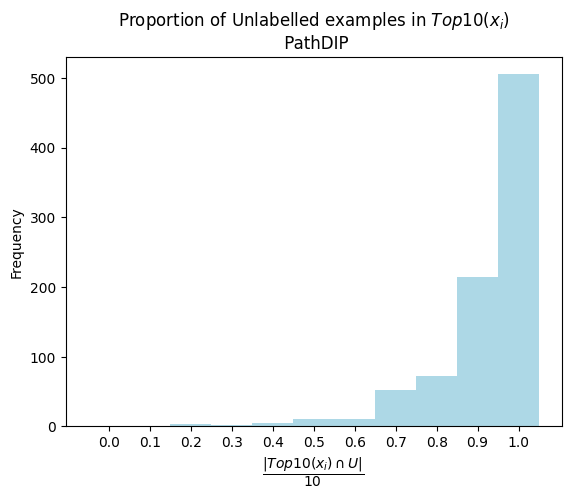

In [93]:
# Plot a histogram of the percentage of top10 closest samples that are unlabeled
print(jaccard_top10_percent)
plt.hist(jaccard_top10_percent, bins=[(i-1)/10+1/(10*2) for i in range(12)], color='lightblue')
plt.xlabel('$\dfrac{|Top10(x_i) \cap U|}{10}$')
plt.xticks(np.arange(0, 1.1, 0.1))
plt.ylabel('Frequency')
plt.title('Proportion of Unlabelled examples in $Top10(x_i)$\n GO')
plt.show()